### Пример регуляризации логистической регрессии
### Подбор гиперпараметров

Источник: https://habr.com/ru/company/ods/blog/323890/

В наборе данных "microchip.txt" для 118 микрочипов (объектов) указаны результаты двух тестов по контролю качества (test_1, test_2). Целевая переменная target принимает 2 значения: 1 - чип выпущен, 0 - чип бракован.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('microchip.txt', names = ['test_1', 'test_2', 'target'])

In [3]:
df.head()

,test_1,test_2,target
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
df['target'].value_counts()

0    60
1    58
Name: target, dtype: int64

In [5]:
X = df[['test_1', 'test_2']].values  # признаки
y = df['target']                     # ответ

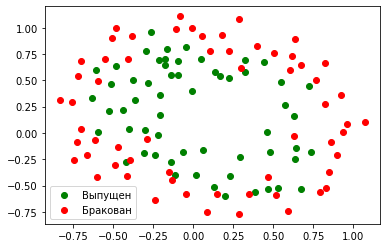

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.legend()

Можно ли разделить объекты на графике прямой линией?  

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=7) 
X_poly = poly.fit_transform(X) # преобразуем признаки

In [8]:
import numpy as np

# Функция для отображения разделяющей кривой
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

$C$ – обратный коэффициент регуляризации. В случае L2-регуляризации к функционалу $Q$ добавляется
    <a href="https://imgbb.com/"><img src="https://i.ibb.co/PNP8b7q/5.jpg" alt="5" border="0"></a>

Доля правильных ответов классификатора на обучающей выборке: 0.627


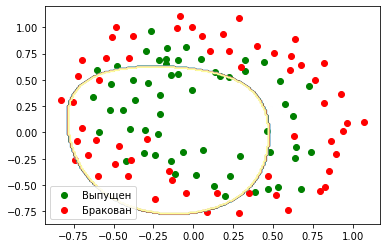

In [9]:
from sklearn.linear_model import LogisticRegression 

# Создадим модель с C = 0.01
logit = LogisticRegression(C=0.01)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.legend()

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Слишком сильная регуляризация, модель недообучилась.

Доля правильных ответов классификатора на обучающей выборке: 0.831


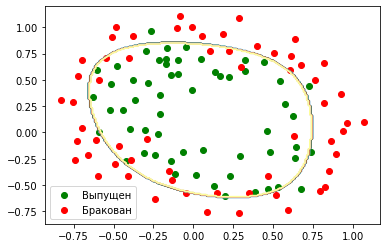

In [10]:
# Создадим модель с С = 1 - ослабим регуляризацию, т.е.значения весов логистической регрессии могут оказаться больше по модулю
logit = LogisticRegression(C=1)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.legend()

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Результат получился гораздо лучше.

Доля правильных ответов классификатора на обучающей выборке: 0.873


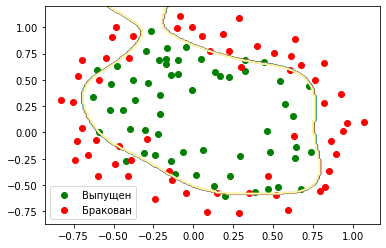

In [11]:
# Создадим модель с С = 10000
logit = LogisticRegression(C=10000, max_iter = 1500)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.legend()

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Слишком слабая регуляризация, модель переобучилась.

#### Как найти оптимальное значение C?

In [12]:
from sklearn.linear_model import LogisticRegressionCV
logitcv = LogisticRegressionCV(max_iter = 1000)
logitcv.fit(X_poly, y)
print("Доля правильных ответов классификатора на обучающей выборке:", round(logitcv.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.839


##### Поиск по  сетке
Принцип работы метода поиска оптимальных значений гиперпараметров по сетке довольно прост: мы задаем список значений для различных гиперпараметров, и компьютер оценивает качество модели для их каждой комбинации с целью получения оптимального набора значений гиперпараметров.

In [13]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

logit = LogisticRegression(max_iter = 1000)

grid = GridSearchCV(logit, parameters)
grid.fit(X_poly, y)

grid.best_estimator_ # лучшая модель

LogisticRegression(C=100, max_iter=1000)

In [14]:
logit = LogisticRegression(C=100, max_iter = 1000)
logit.fit(X_poly, y)
print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.839


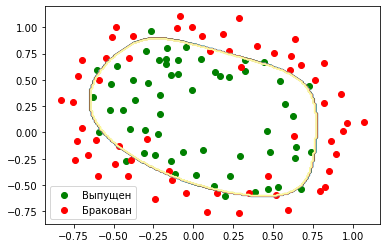

In [15]:
plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.legend()